<a href="https://colab.research.google.com/github/fevdaele/Machine_Learning_course_UGent_D012554_kaggle/blob/master/Kaggle_eye_blinking_prediction_notfinal.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
%matplotlib inline
import matplotlib.pyplot as plt;
import numpy as np;
import pandas as pd;
import seaborn as sns;
sns.set_context("notebook", font_scale=1.4);
sns.set_style("whitegrid");
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score

### **Load train and dataset**

In [0]:
trainset = pd.read_csv("https://raw.githubusercontent.com/sdgroeve/Machine_Learning_course_UGent_D012554_kaggle/master/eeg_train.csv")

testset = pd.read_csv("https://raw.githubusercontent.com/sdgroeve/Machine_Learning_course_UGent_D012554_kaggle/master/eeg_test.csv")

**Data exploration**

Below, the first five rows of the dataset can be found. Each column indicates one of the 14 different locations where brain activity was measured. From now on we will call these locations the predictor variables or so called **features**. Features are the parameters that characterize tha datapoints and predict whether the individual's eyes are open or closed. The **target variable** or label is in this case categorical, dividing the datapoints in two classes; 0 if the eyes are open and 1 if the eyers are closed.

In [96]:
trainset.head()

,AF3,F7,F3,FC5,T7,P7,O1,02,P8,T8,FC6,F4,F8,AF4,label
0,4299.49,3997.44,4277.95,4116.92,4353.85,4623.08,4100.00,4623.59,4202.56,4229.23,4211.79,4278.97,4600.00,4369.23,1
1,4302.05,3985.64,4261.03,4129.74,4334.36,4615.38,4072.31,4585.64,4192.31,4225.13,4195.90,4283.08,4607.18,4358.46,0
2,4321.03,4015.90,4265.13,4122.56,4333.33,4613.33,4072.82,4602.05,4192.31,4223.08,4155.38,4286.15,4608.21,4371.79,0
3,4408.21,4104.10,4380.00,4232.31,4449.74,4750.26,4169.23,4731.28,4311.28,4352.31,4319.49,4388.21,4715.90,4464.10,0
4,4347.18,3975.38,4266.67,4102.56,4333.33,4617.95,4097.44,4612.82,4210.77,4240.51,4248.21,4313.33,4664.10,4411.79,1


**How many datapoints are there for each class?**

In [97]:
print(trainset["label"].value_counts())

0    1099
1     901
Name: label, dtype: int64


### **Data pre processing**
Data pre-processing means that you prepare your data for fitting wit a machine learning model.

**Are there any missing values?**

In [98]:
trainset.isnull().sum().sum()

0

**Define variables for the features**

In [0]:
data_train = trainset.copy()
label_column = data_train.pop('label')

data_test = testset.copy()
index_column = data_test.pop('index')

columns_train = data_train.columns.values.tolist()

**Scaling of train- and testset**

Scaling your features is important since it helps to normalize the data within a particular range and can result in better performance.

Some elements used in learning algorithms, such as the radial basis kernel function (rbf) used in this algorithm (cfr. later), assume that the data is centerd around zero. Therefore the data was normalized by standardization rather than min-max normalization.

By **fitting** the scaler, the means of the features in the dataset are calculated and applied to the dataset by **transforming** the data. By transforming your data, missing values will be replaced by means for example.

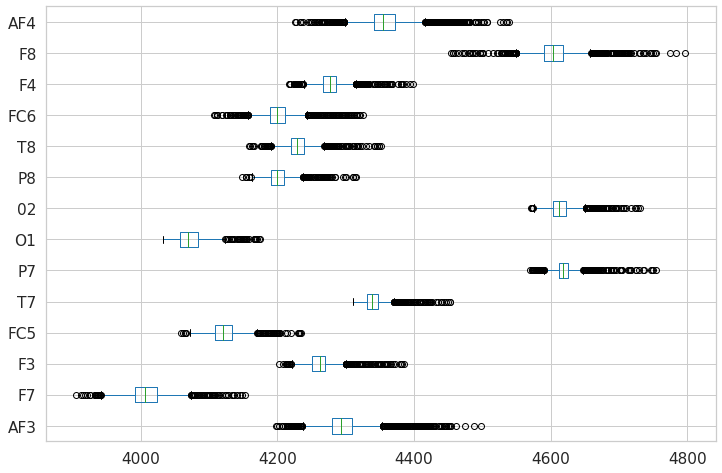

In [100]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

data_train = scaler.fit_transform(data_train)
data_train = pd.DataFrame(data_train, columns=columns_train)

data_test = scaler.transform(data_test)

#boxplot of unscaled trainset
plt.figure(figsize=(12,8))
trainset.pop('label')
trainset.boxplot(vert=False)
plt.show()

The upper boxplot shows the unscaled training dataset.

The boxplot below shows the scaled training dataset, nicely centered around zero.

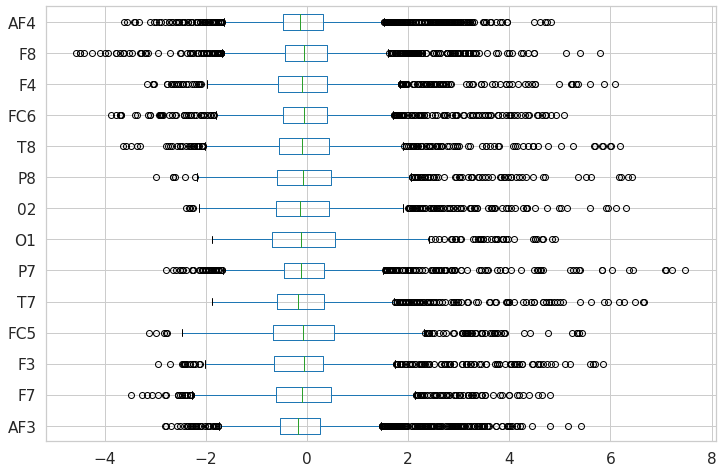

In [101]:
#boxplot of scaled trainsetplt.figure(figsize=(12,8))
plt.figure(figsize=(12,8))
data_train.boxplot(vert=False)
plt.show()

### ***Model selection and validation***

***Model Selection***

Choosing a model that can solve the task is the next step in building a prediction model. In this case we have a **two class classification task**, so regression models can't be used, since they work with continuous target variables. 

**Support Vector Machine** is a model that solves two class classification tasks, and uses *Kernel functions*, which allow you to compute linear decision boundries, without doing polynomial transformations.

The Kernel function that was applied in this example is the **radial basis function (rbf)**.

***Model Validation***

To check how well your model performs on your train set, cross validation can be applied. By using cross validation, the dataset will be split up in smaller subsets, and each time 1 subset will be used as train set, and the other subsets as dataset. The amount of subsets, called folds, can be determinded by yourself. In this case a 10-fold cross validation (cv=10) was applied with the area under the curve (auc) as scoring method.

In [102]:
from sklearn.svm import SVC

y = label_column
X = data_train

model = SVC(kernel='rbf', gamma=1 , C=1)

score_auc = cross_val_score(model, data_train, y=label_column, scoring = 'roc_auc', cv=10).mean()
print(score_auc)


0.9581062148860315


### ***Model optimization***

The auc score of this model seems good, but let's see if we can do better.

Model optimization means **fine tuning the hyperparameters** to obtain a model with optimal peformance. 

The hyperparameters that can be fine tuned in this model are **regularization constant C** and **kernel hyperparameter gamma**.

By creating a so called *search space*, you specify which values for the hyperparameters you want the grid search function to fit and validate. As a result, it returns the parameters that have the best score.

In [103]:
from sklearn.model_selection import GridSearchCV, cross_val_predict
from sklearn import metrics

X = data_train
y = label_column


search_space_C = [0.001, 0.01, 0.1, 1, 10]
search_space_gamma = [1, 2, 3, 4, 5, 6]
param_grid = {'gamma': search_space_gamma, 'C' : search_space_C}
grid_search = GridSearchCV(model, param_grid, scoring = 'roc_auc', cv=10)
grid_search.fit(X, y)

print(grid_search.best_estimator_)
print(grid_search.best_params_)
print(grid_search.best_score_)


SVC(C=10, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=1, kernel='rbf', max_iter=-1,
    probability=False, random_state=None, shrinking=True, tol=0.001,
    verbose=False)
{'C': 10, 'gamma': 1}
0.9625710354884667


Since the best parameters have values that are both limits of the search space, othe search spaces were created to check for potentially better parameters.

In [104]:
X = data_train
y = label_column


search_space_C = [10, 15, 20, 40, 70, 100]
search_space_gamma = [0.001, 0.01, 0.1, 0.5, 1]
param_grid = {'gamma': search_space_gamma, 'C' : search_space_C}
grid_search = GridSearchCV(model, param_grid, scoring = 'roc_auc', cv=10)
grid_search.fit(X, y)

print(grid_search.best_estimator_)
print(grid_search.best_params_)
print(grid_search.best_score_)

SVC(C=10, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=0.5, kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)
{'C': 10, 'gamma': 0.5}
0.9649338785577317


The auc score slightly increased by finding a better value for hyperparameter gamma. The best value for hyperparameter C remained the same. 

Another factor that contributes to the optimizing a model is the number of cross validation folds. In the previous models, a 10-fold cross validation was applied. Let's see if the auc score increases by increasing the number of folds.

In [0]:
X = data_train
y = label_column


search_space_C = [10, 15, 20, 40, 70, 100]
search_space_gamma = [0.001, 0.01, 0.1, 0.5, 1]
param_grid = {'gamma': search_space_gamma, 'C' : search_space_C}
grid_search = GridSearchCV(model, param_grid, scoring = 'roc_auc', cv=100)
grid_search.fit(X, y)

print(grid_search.best_estimator_)
print(grid_search.best_params_)
print(grid_search.best_score_)

Note that both values for hyperparameters C and gamma changed by using a higher fold, resulting in, again, a slight increasement of the auc score.

**Define model with optimized hyperparameters**

Now that we have optimized the model, the model needs to be defined again, to make sure the optimized model will be fitted.

In [0]:
model2 = SVC(kernel='rbf', gamma=0.1, C=40, probability=True)

### ***Fit model on trainset***

By fitting the model on you train set, you make the algorithm learn the relationship between predictors and outcome.

In [106]:
model2.fit(X,y)

SVC(C=40, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=0.1, kernel='rbf',
    max_iter=-1, probability=True, random_state=None, shrinking=True, tol=0.001,
    verbose=False)

### ***Make predictions***

In [107]:
predictions_model2 = model2.predict_proba(data_test)
print(predictions_model2)

[[9.99994810e-01 5.18970235e-06]
 [2.10386678e-01 7.89613322e-01]
 [9.96911520e-01 3.08847964e-03]
 ...
 [2.66664163e-03 9.97333358e-01]
 [2.20256372e-01 7.79743628e-01]
 [9.39388770e-01 6.06112302e-02]]


**Create new dataframe to load predictions**

In [108]:
PredictionsFemke_model2 = pd.DataFrame(columns=['index','0', '1'])
PredictionsFemke_model2['index'] = index_column
PredictionsFemke_model2['1'] = predictions_model2[:,1]
PredictionsFemke_model2['0'] = predictions_model2[:,0]

print(PredictionsFemke_model2)

       index             0         1
0          0  9.999948e-01  0.000005
1          1  2.103867e-01  0.789613
2          2  9.969115e-01  0.003088
3          3  1.604755e-06  0.999998
4          4  2.548073e-09  1.000000
...      ...           ...       ...
12887  12887  8.934933e-01  0.106507
12888  12888  7.310693e-06  0.999993
12889  12889  2.666642e-03  0.997333
12890  12890  2.202564e-01  0.779744
12891  12891  9.393888e-01  0.060611

[12892 rows x 3 columns]


**Scatterplot of predictions made by the 2nd best model**

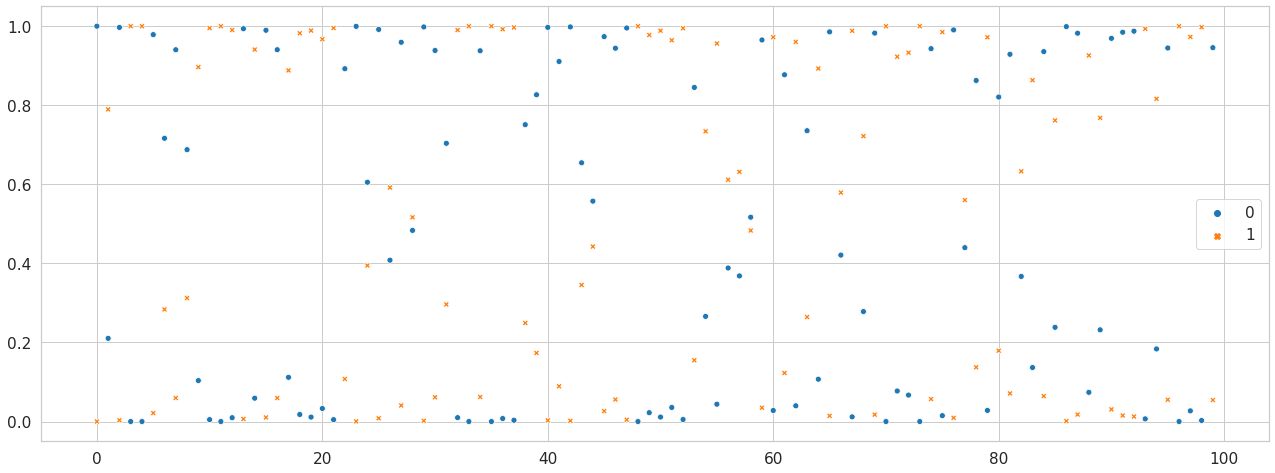

In [109]:
PredictionsFemke_model2.pop('index')
 
plt.figure(figsize=(22,8))
sns.scatterplot(data = PredictionsFemke_model2.iloc[:100,])
plt.show()

### **Save predictions in csv file**

In [0]:
filename = "PredictionsFemke14052020_version1.csv"

#make sure to not write the Pandas index column (index=False)
PredictionsFemke.to_csv(filename,index=False)

### **Discussion**
Although the final model described above performed well on the test dataset with an auc = 0.96812, the previously described model with hyperparameters C = 10 and gamma = 1 performed even better, with an auc = 0.97424. 

In [111]:
model1 = SVC(kernel='rbf', gamma=1, C=10, probability=True)
model1.fit(X,y)

SVC(C=10, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=1, kernel='rbf', max_iter=-1,
    probability=True, random_state=None, shrinking=True, tol=0.001,
    verbose=False)

In [112]:
predictions = model1.predict_proba(data_test)
print(predictions)

[[0.99621376 0.00378624]
 [0.63533921 0.36466079]
 [0.99256149 0.00743851]
 ...
 [0.11716892 0.88283108]
 [0.05516662 0.94483338]
 [0.99475293 0.00524707]]


In [113]:
PredictionsFemke_model1 = pd.DataFrame(columns=['index','0', '1'])
PredictionsFemke_model1['index'] = index_column
PredictionsFemke_model1['1'] = predictions_model2[:,1]
PredictionsFemke_model1['0'] = predictions_model2[:,0]

print(PredictionsFemke_model1)

       index             0         1
0          0  9.999948e-01  0.000005
1          1  2.103867e-01  0.789613
2          2  9.969115e-01  0.003088
3          3  1.604755e-06  0.999998
4          4  2.548073e-09  1.000000
...      ...           ...       ...
12887  12887  8.934933e-01  0.106507
12888  12888  7.310693e-06  0.999993
12889  12889  2.666642e-03  0.997333
12890  12890  2.202564e-01  0.779744
12891  12891  9.393888e-01  0.060611

[12892 rows x 3 columns]


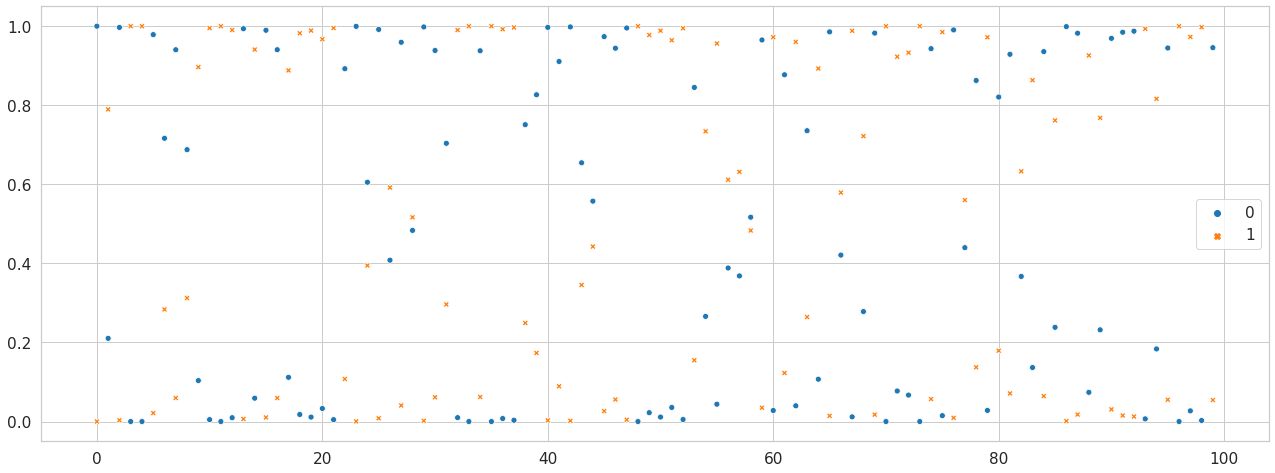

In [114]:
PredictionsFemke_model1.pop('index')
 
plt.figure(figsize=(22,8))
sns.scatterplot(data = PredictionsFemke_model1.iloc[:100,])
plt.show()

In [116]:
Pred_model1 = PredictionsFemke_model1.iloc[:100,]
Pred_model2 = PredictionsFemke_model2.iloc[:100,]

concatenated = pd.concat([Pred_model1.assign(dataset='PredictionsFemke_model1'), Pred_model2.assign(dataset='PredictionsFemke_model2')])
sns.scatterplot(data=concatenated)
plt.show()

ValueError: ignored